In [7]:
using LinearAlgebra, CSV, Statistics, DataFrames, Plots, DelimitedFiles
flatten(x) = [x[i] for i in eachindex(x)]
X = convert(Array, CSV.read("C:\\Users\\april\\Documents\\schoolwork\\Numerik\\hitters.x.csv", DataFrame))
y = convert(Array, CSV.read("C:\\Users\\april\\Documents\\schoolwork\\Numerik\\hitters.y.csv", DataFrame))
headers = readdlm("C:\\Users\\april\\Documents\\schoolwork\\Numerik\\hitters.x.csv", ',')[1, :]
n, d = size(X)

(263, 19)

1. Scaling the features to have variance 1 drastically decreases the norm of each feature, which in turn decreases the variance of the estimator $\mathbb{E}\left[ \left( \hat{h}(x) - \mathbb{E}\left[ \hat{h}(x) \right] \right) ^2 \right]$. It also allows comparison between elements of $\theta$. 

In [8]:
# 1. 
scale = 1 ./ sqrt.(var(X, dims=2)) |> flatten |> Diagonal
X, y = scale*X, scale*y;

2\. We can write $ \tilde{X} = [1\ X], \ \tilde{y}^T = [1\ y^T] $ and for theta we write $ \hat{\theta} = \text{argmin}_\theta\  \| \tilde{y} - \tilde{X}\theta \|^2 + \lambda\| \tilde{I}\theta \|^2  $, with 

$$
    \tilde{I}=\begin{bmatrix}
        0 & & & \\
        & 1 & & \\
        & & \ddots & \\
        & & & 1
    \end{bmatrix} = I - \begin{bmatrix}
        1 & & & \\
        & 0 & & \\
        & & \ddots & \\
        & & & 0 
    \end{bmatrix}
$$.

This is solved almost identically to the least squares regression: we have
$$
\begin{align*}
    \hat{\theta} &= \text{argmin}_\theta\ R(\theta) \\
    &= \text{argmin}_\theta\ \| \tilde{y} - \tilde{X}\theta \|^2 + \lambda\| \tilde{I}\theta \| ^2 \\
    &= \langle \tilde{y} - \tilde{X}\theta,\ \tilde{y} - \tilde{X}\theta \rangle + \lambda\langle\tilde{I}\theta,\ \tilde{I}\theta\rangle \\
    &= \tilde{y}^T \tilde{y} +\theta^T\tilde{X}^T\tilde{X}\theta - 2\theta^T\tilde{X}^T\tilde{y} + \lambda\theta^T\tilde{I}^T\tilde{I}\theta \\
\end{align*}
$$

which is solved by $ \left(\tilde{X}^T\tilde{X} + \lambda\tilde{I}\right)\hat{\theta} = \tilde{X}^T\tilde{y} $, after setting the gradient to 0. This can be solved via Cholesky decomposition since $ \tilde{X}^T\tilde{X} $ and $ \tilde{I}^T\tilde{I} = \tilde{I} $ are both symmetric positive definite matrices. 

In [9]:
# 2.
X = hcat(ones(n), X)
n, d = size(X)
Ĩ = Diagonal([ 0; ones(d-1) ]);

&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

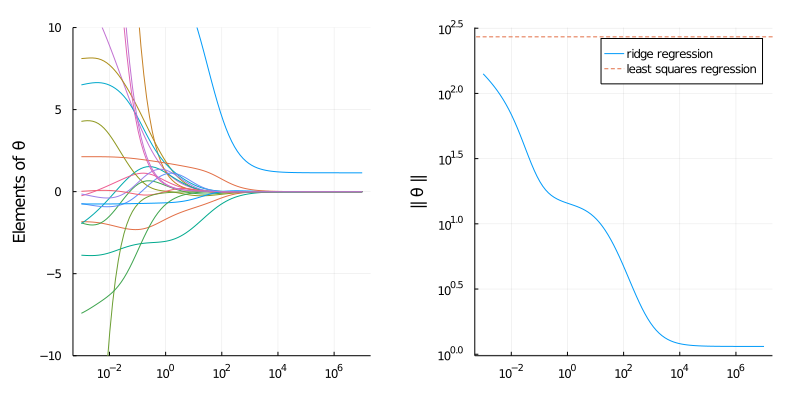

In [10]:
# 3. and 4.
λ = 10 .^ range(-3, 7, length=100)
θ = [(X'X + λᵢ*Ĩ) \ X'y for λᵢ in λ]

fig1 = plot(λ, [[getindex(θ[i], j) for i in eachindex(θ)] for j in eachindex(θ[1])], 
            xaxis=:log10, yaxis=((-10, 10), "Elements of θ"), lab=false)

θ = norm.(θ)
fig2 = plot(λ, θ, xaxis=:log10, yaxis=(:log10, "|| θ ||"), lab="ridge regression")
fig2 = hline!([norm( X'X \ X'y )], linestyle=:dash, lab="least squares regression")

fig = plot(fig1, fig2, layout=2, size=(800, 400), margin=5Plots.mm)

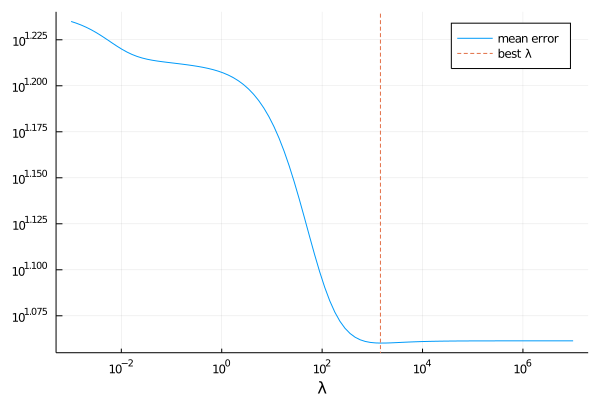

In [16]:
# 5.
Xy = sortslices(hcat(X, y), by=x -> rand(), dims=1)                # shuffle
X, y = Xy[:, 1:end-1], Xy[:, end]

i, k = 1, 5                                                        # initialize
m = round(Int, n / k, RoundDown)
err = Array{Float64,2}(undef, 100, k)
θ_cross = Array{Float64,2}(undef, d, k)

for i in 1:k                                                       # split dataset
    val = m*(i-1) + 1 : m*i                                        # into k parts
    train = filter(j -> !(j in m*(i-1) + 1 : m*i), 1:n)
    X_val, y_val = X[val, :], y[val]
    X_train, y_train = X[train, :], y[train]               

    θ = [ (X_train'X_train + λᵢ*Ĩ) \ X_train'y_train for λᵢ in λ ] # train model
    err[:, i] = [ norm( y_val - X_val*θᵢ ) for θᵢ in θ ]
    θ_cross[:, i] = θ[argmin( err[:, i] )]                         # save best result
end

err = mean(err, dims=2)                                            # average error
fig = plot(λ, err, xaxis=(:log10, "λ"), yaxis=:log10, lab="mean error")
fig = vline!([λ[argmin(err)]], linestyle=:dash, lab="best λ")

In [15]:
# 6.
θ_cross = mean(θ_cross, dims=2)
p = filter(x -> x !== d, sortperm(flatten(θ_cross), by=abs, rev=true))
permutedims(headers[p])
# from most important to least important:

1×19 Array{Any,2}:
 "CAtBat"  "DivisionW"  "AtBat"  "NewLeagueN"  …  "CRBI"  "CWalks"  "LeagueN"